# Audio Speech Commands Recognition

* Data Repository: https://upatrasgr-my.sharepoint.com/:u:/g/personal/ceid3565_upatras_gr/EcUKreKCY0tHvjjfma33pkwBTU522U-WKjrRaJgnQ_ghLg?e=2w6Bdd
* The tutorial is based on: https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
%load_ext autoreload
%autoreload 2

## Bind GPUs

In [2]:
import os
# Set CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Replace "3" with the desired GPU IDs, separated by commas

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pathlib
import yaml
from datetime import datetime
import time

import numpy as np
from tensorflow import keras
import pandas as pd

from IPython import display

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Disable Warnings
def warn(*args, **kwargs):
    """Eliminating warnings from scikit-learn.
    
    """
    pass
import warnings
warnings.warn = warn

# disable all warnings from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-09-26 18:02:12.169743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 18:02:12.887232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/konto/anaconda3/envs/crossai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
now = datetime.now()
print("date and time of NB execution =", now.strftime("%d/%m/%Y %H:%M:%S"))
start_time = time.time()

date and time of NB execution = 26/09/2023 18:02:14


## Bind GPUs

In [5]:
# Set CUDA_VISIBLE_DEVICES environment variable
# os.environ["CUDA_VISIBLE_DEVICES"] = "3, 4"  # Replace "3" with the desired GPU IDs, separated by commas

In [6]:
def exploit_physical_growth() -> None:
    """Set memory growth for all PhysicalDevices available.
       This prevents tensorflow from allocating all memory on the device
       link: https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
    """

    gpus = tf.config.list_physical_devices('GPU')
    print(f"Set up growth dynamic limit in all the available GPUs: {gpus}", "info")
    if gpus:
        try:
            for i in range(len(gpus)):
                tf.config.experimental.set_memory_growth(gpus[i], True)
                print("Growth set for GPU {}".format(i), "debug")
                assert tf.config.experimental.get_memory_growth(gpus[i])
            print("Growth for all the GPUs was set up successfully.", "success")
        except RuntimeError as e:
            print("No successful set up of GPUs' growth.")
            print(e)

In [7]:
exploit_physical_growth()

Set up growth dynamic limit in all the available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] info
Growth set for GPU 0 debug
Growth for all the GPUs was set up successfully. success


## Load configuration file and dataset path

In [8]:
with open("../config.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [9]:
DATASET_PATH = config["DATA_PATH"]
data_dir = pathlib.Path(DATASET_PATH)

In [10]:
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

## Show audio commands

The dataset's audio clips are stored in eight folders corresponding to each speech command

In [11]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['left' 'go' 'right' 'up' 'stop' 'yes' 'down' 'no']


## Load data into training and test sets

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [12]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


2023-09-26 18:02:15.966547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38198 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:4d:00.0, compute capability: 8.0


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`

In [13]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis

In [14]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over any shard will load all the data, and only keep its fraction. 

In [15]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [16]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


## Plot audio waveforms as an example

In [17]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

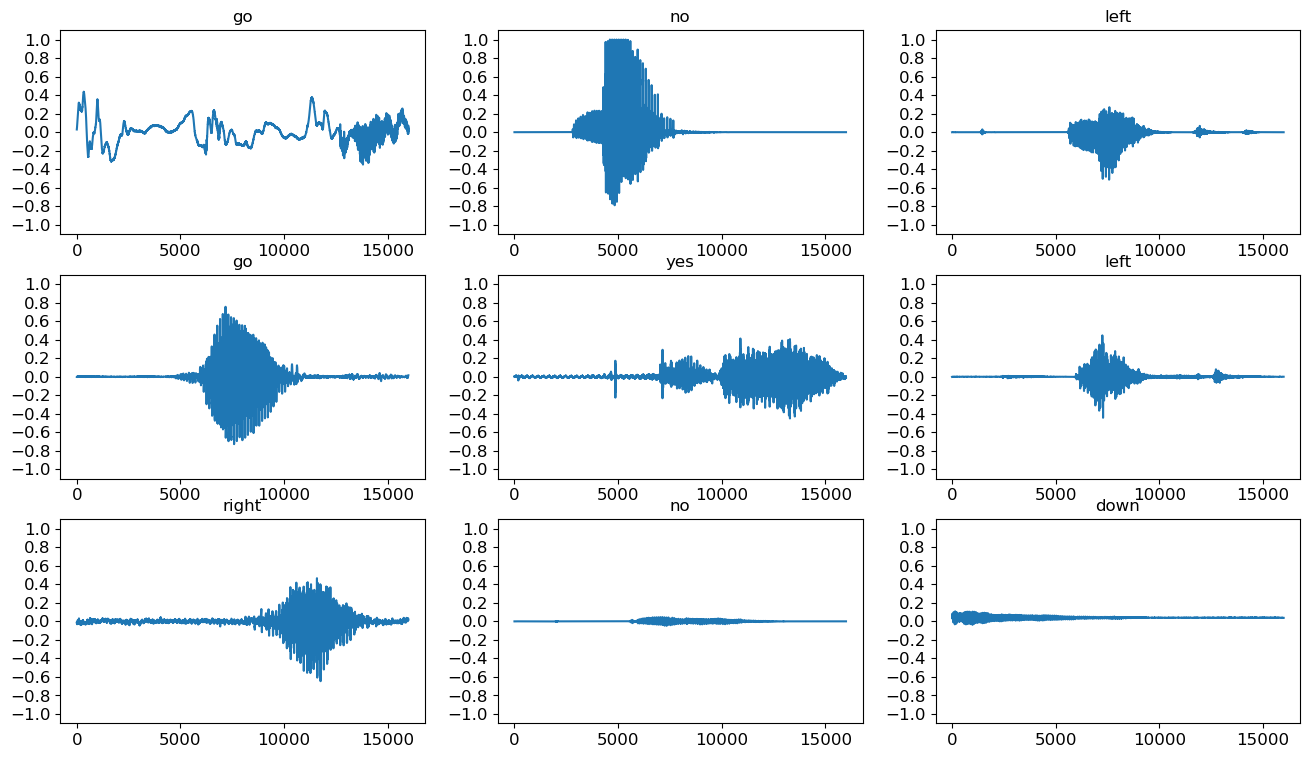

In [18]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

## Convert waveforms to spectrograms

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

* The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
* When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square.
* The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [19]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio

In [20]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Define a function for displaying a spectrogram

In [21]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time)

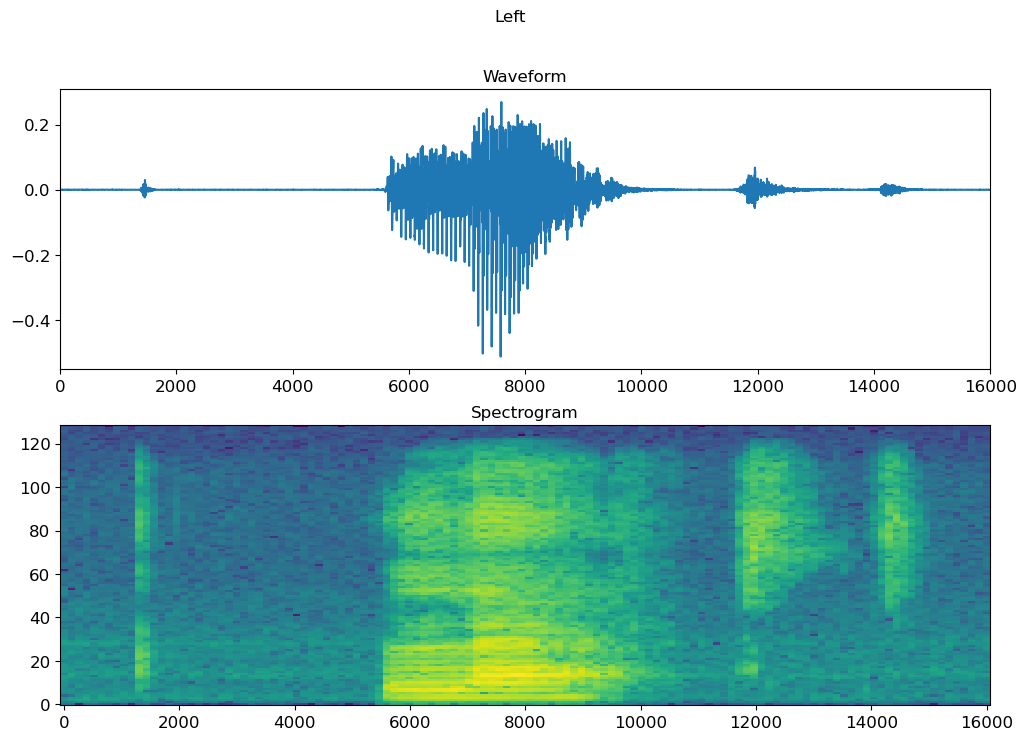

In [22]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [23]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [25]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

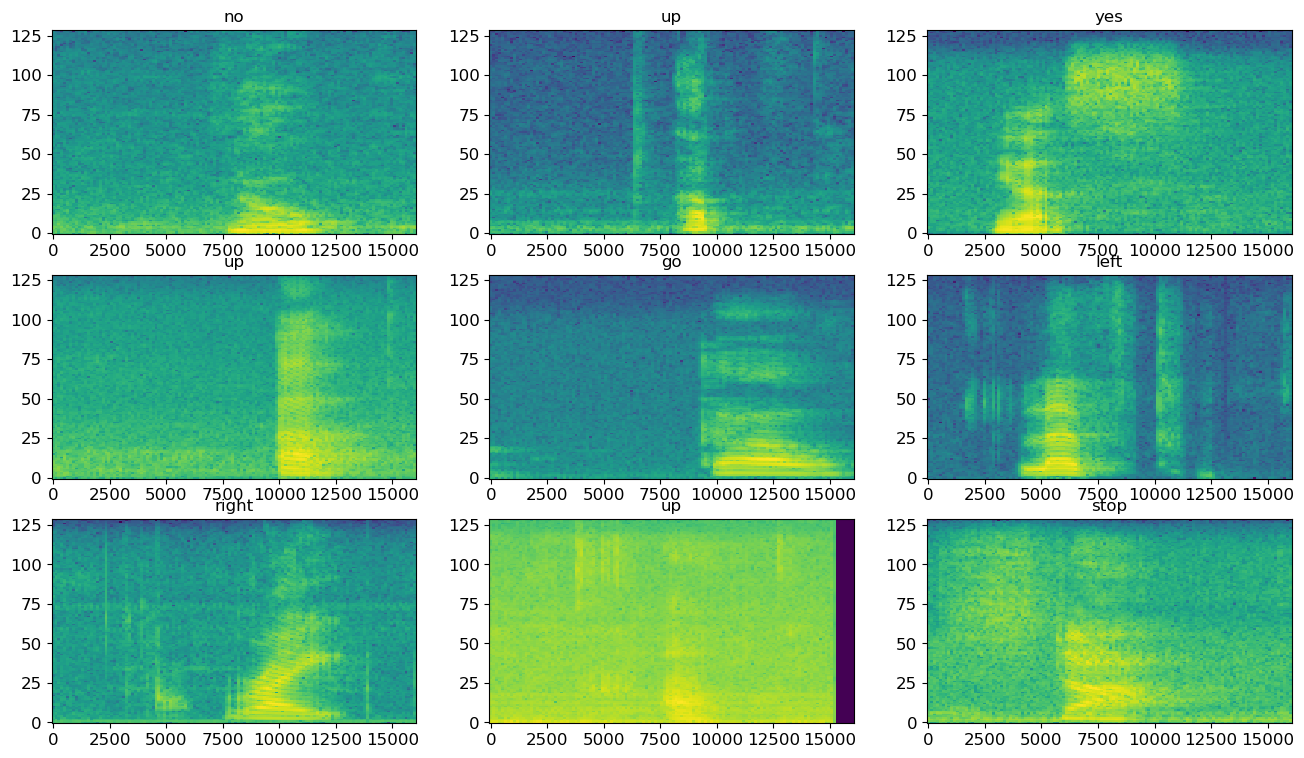

In [26]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Build and train the model
Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

In [27]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.
- For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [28]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
print('Number of classes:', num_labels)

Input shape: (124, 129, 1)
Number of classes: 8


#### AI Modelling

In [29]:
from crossai_lib.models.nn2d import CNN2D

In [30]:
cnn2d = CNN2D(input_shape=input_shape, num_classes=num_labels)
cnn2d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 124, 129, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 122, 127, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 125, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 41, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 39, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 37, 128)       147584    
                                                             

In [31]:
cnn2d.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [32]:
EPOCHS = 10
history = cnn2d.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=2, patience=2),
)

Epoch 1/10


2023-09-26 18:02:22.802613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-26 18:02:23.320685: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-26 18:02:23.640686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-26 18:02:23.643201: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e841ed5de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-26 18:02:23.643253: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-09-26 18:02:23.653862: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-26 18:02:23.763247:

100/100 [==============================] - 7s 19ms/step - loss: 2.0228 - accuracy: 0.1847 - val_loss: 1.9391 - val_accuracy: 0.2070
Epoch 2/10
100/100 [==============================] - 1s 14ms/step - loss: 1.7163 - accuracy: 0.3664 - val_loss: 1.5935 - val_accuracy: 0.4414
Epoch 3/10
100/100 [==============================] - 1s 15ms/step - loss: 1.3973 - accuracy: 0.5130 - val_loss: 1.2718 - val_accuracy: 0.5885
Epoch 4/10
100/100 [==============================] - 1s 15ms/step - loss: 1.1730 - accuracy: 0.6161 - val_loss: 1.1316 - val_accuracy: 0.6576
Epoch 5/10
100/100 [==============================] - 1s 15ms/step - loss: 1.0161 - accuracy: 0.6716 - val_loss: 0.9083 - val_accuracy: 0.7148
Epoch 6/10
100/100 [==============================] - 1s 15ms/step - loss: 0.8770 - accuracy: 0.7161 - val_loss: 0.8711 - val_accuracy: 0.7318
Epoch 7/10
100/100 [==============================] - 1s 15ms/step - loss: 0.7694 - accuracy: 0.7550 - val_loss: 0.7588 - val_accuracy: 0.7487
Epoch 8/10

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

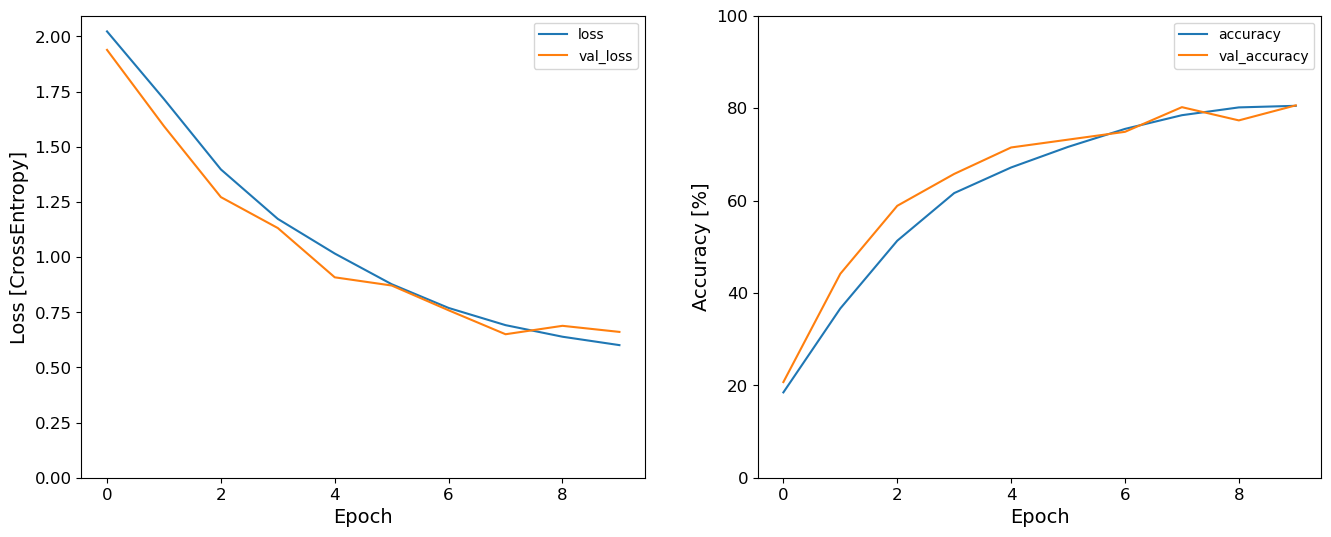

In [33]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [34]:
cnn2d.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 7ms/step - loss: 0.5772 - accuracy: 0.8269


{'loss': 0.5772491693496704, 'accuracy': 0.8269230723381042}

### Xception using the top layer as a model output for classification

In [35]:
from crossai_lib.models.nn2d import Xception

Build the model. By TF convention, drop batch size (number of instances) dimension

In [36]:
model = Xception(input_shape=input_shape, num_classes=num_labels)

Show model summary

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 61, 64, 32)           320       ['input_layer[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 61, 64, 32)           128       ['conv2d_4[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 61, 64, 32)           0         ['batch_normalization[0]

Plot the model to verify the inner structure

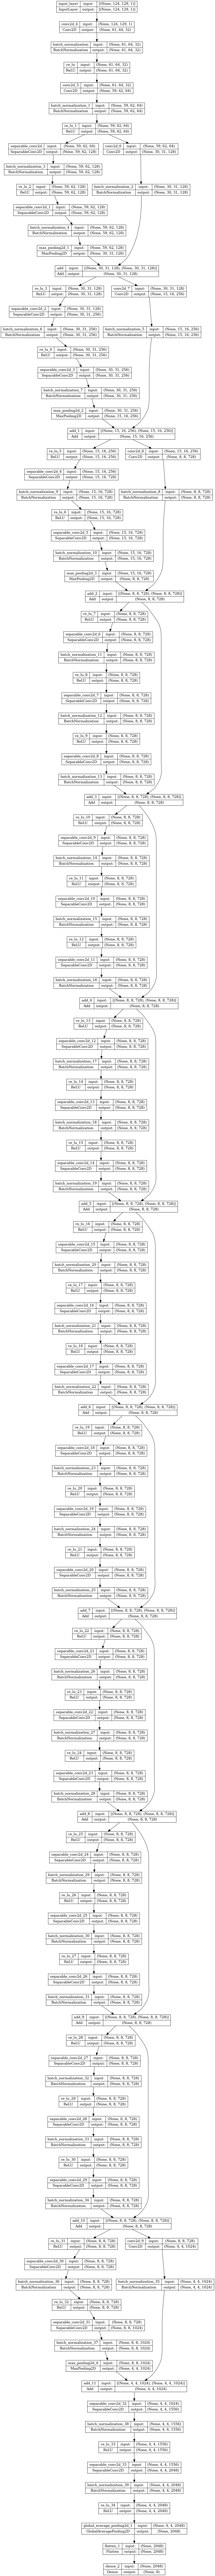

In [38]:
keras.utils.plot_model(model, to_file='Xception.png', show_shapes=True)

Set up optmizer, compile, and train the model

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [40]:

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    verbose=2,
    epochs=10,
)

Epoch 1/10
100/100 - 35s - loss: 1.6977 - accuracy: 0.5822 - val_loss: 2.6223 - val_accuracy: 0.1927 - 35s/epoch - 354ms/step
Epoch 2/10
100/100 - 7s - loss: 0.9070 - accuracy: 0.8734 - val_loss: 2.6047 - val_accuracy: 0.1276 - 7s/epoch - 71ms/step
Epoch 3/10
100/100 - 7s - loss: 0.7193 - accuracy: 0.9297 - val_loss: 2.5780 - val_accuracy: 0.1471 - 7s/epoch - 71ms/step
Epoch 4/10
100/100 - 7s - loss: 0.6609 - accuracy: 0.9419 - val_loss: 2.3986 - val_accuracy: 0.3555 - 7s/epoch - 71ms/step
Epoch 5/10
100/100 - 7s - loss: 0.5797 - accuracy: 0.9589 - val_loss: 1.1336 - val_accuracy: 0.8411 - 7s/epoch - 70ms/step
Epoch 6/10
100/100 - 7s - loss: 0.5279 - accuracy: 0.9667 - val_loss: 0.6697 - val_accuracy: 0.9193 - 7s/epoch - 71ms/step
Epoch 7/10
100/100 - 7s - loss: 0.5098 - accuracy: 0.9650 - val_loss: 0.7428 - val_accuracy: 0.9049 - 7s/epoch - 70ms/step
Epoch 8/10
100/100 - 7s - loss: 0.4692 - accuracy: 0.9712 - val_loss: 0.6991 - val_accuracy: 0.9062 - 7s/epoch - 71ms/step
Epoch 9/10
10

Show history info

In [41]:
history.params

{'verbose': 2, 'epochs': 10, 'steps': 100}

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

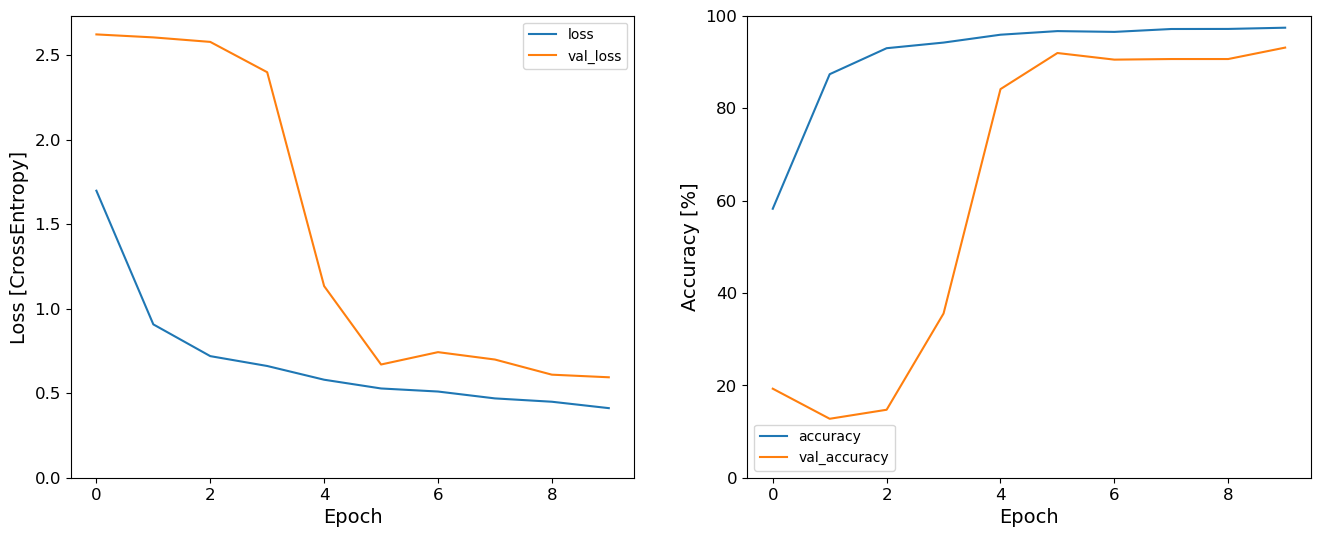

In [43]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Evaluate the model on test data

In [44]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 15ms/step - loss: 0.6247 - accuracy: 0.9303


{'loss': 0.6247223615646362, 'accuracy': 0.9302884340286255}

### ResNet34 using the top layer as a model output for classification

In [45]:
from crossai_lib.models.nn2d import ResNet34

In [46]:
resnet = ResNet34(input_shape=input_shape, num_classes=num_labels)

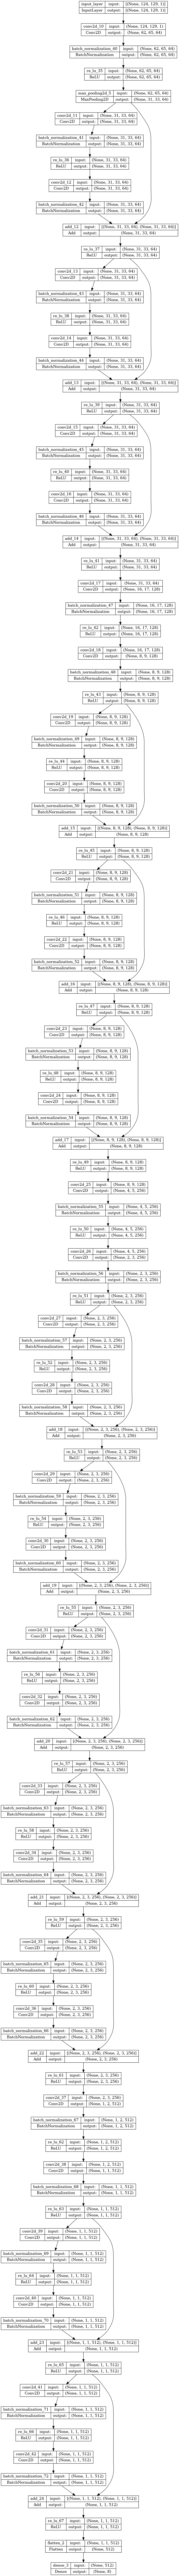

In [47]:
keras.utils.plot_model(resnet, to_file="ResNet34.png", show_shapes=True)

In [48]:
resnet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [49]:
history = resnet.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    verbose=2,
    epochs=10,
)

Epoch 1/10
100/100 - 22s - loss: 13.0561 - accuracy: 0.1338 - val_loss: 23.4276 - val_accuracy: 0.1315 - 22s/epoch - 222ms/step
Epoch 2/10
100/100 - 4s - loss: 10.7949 - accuracy: 0.1366 - val_loss: 9.9941 - val_accuracy: 0.1263 - 4s/epoch - 40ms/step
Epoch 3/10
100/100 - 4s - loss: 8.9111 - accuracy: 0.2625 - val_loss: 8.3871 - val_accuracy: 0.2161 - 4s/epoch - 40ms/step
Epoch 4/10
100/100 - 4s - loss: 6.7853 - accuracy: 0.5984 - val_loss: 7.8834 - val_accuracy: 0.2044 - 4s/epoch - 40ms/step
Epoch 5/10
100/100 - 4s - loss: 5.3173 - accuracy: 0.7869 - val_loss: 5.4674 - val_accuracy: 0.5781 - 4s/epoch - 40ms/step
Epoch 6/10
100/100 - 4s - loss: 4.2874 - accuracy: 0.8545 - val_loss: 3.9635 - val_accuracy: 0.8451 - 4s/epoch - 40ms/step
Epoch 7/10
100/100 - 4s - loss: 3.5049 - accuracy: 0.8911 - val_loss: 3.3557 - val_accuracy: 0.8516 - 4s/epoch - 40ms/step
Epoch 8/10
100/100 - 4s - loss: 2.8937 - accuracy: 0.9141 - val_loss: 5.2869 - val_accuracy: 0.3789 - 4s/epoch - 40ms/step
Epoch 9/10

In [50]:
resnet.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 8ms/step - loss: 2.0690 - accuracy: 0.8906


{'loss': 2.069019079208374, 'accuracy': 0.890625}

Text(0, 0.5, 'Accuracy [%]')

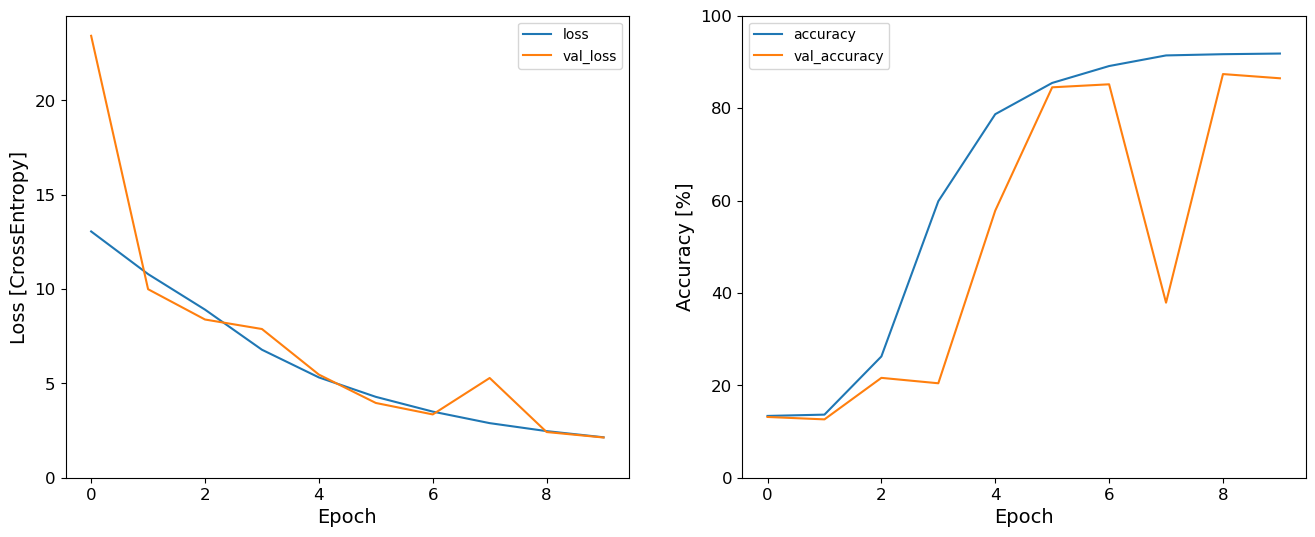

In [51]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### VGG16 using the top layer as a model output for classification

In [52]:
from crossai_lib.models.nn2d import VGG16

In [53]:
vgg16 = VGG16(input_shape=input_shape, num_classes=num_labels)#, dense_layers=2, dense_units=[4096, 4096])

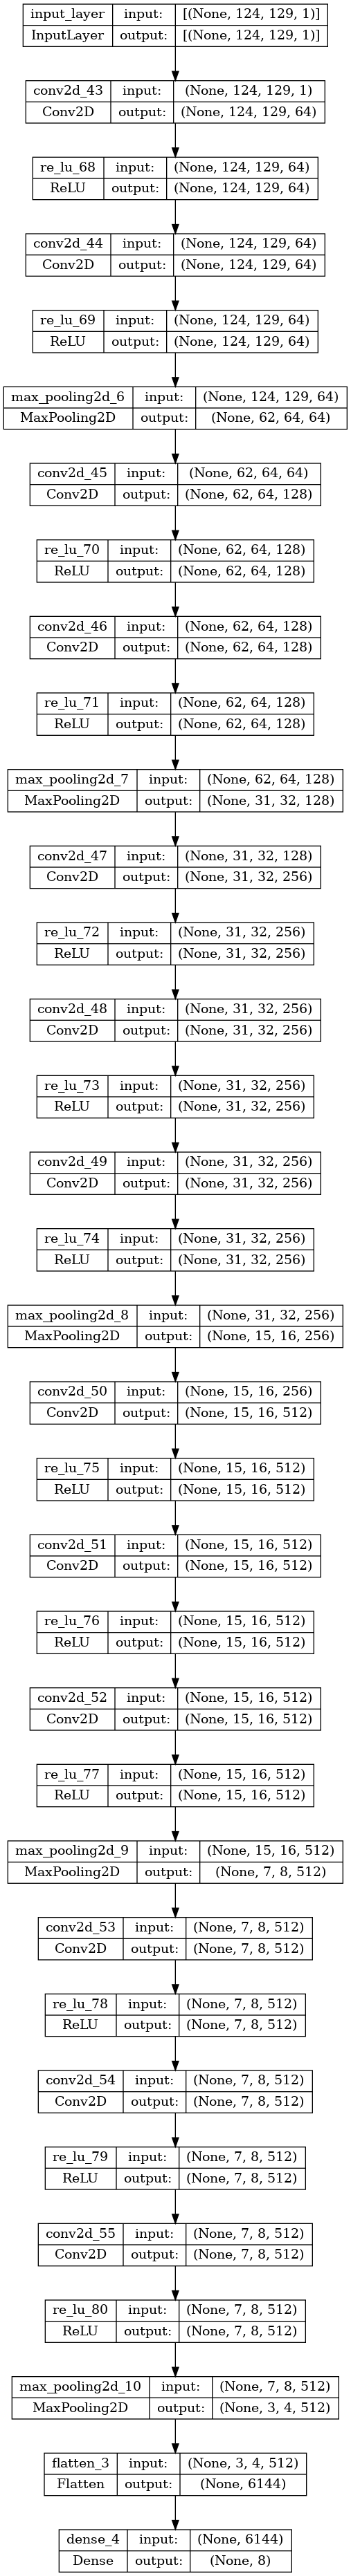

In [54]:
keras.utils.plot_model(vgg16, to_file="VGG16.png", show_shapes=True)

In [55]:
vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [56]:
history = vgg16.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    verbose=2,
    epochs=10,
)

Epoch 1/10
100/100 - 10s - loss: 2.8889 - accuracy: 0.2102 - val_loss: 1.8502 - val_accuracy: 0.3555 - 10s/epoch - 102ms/step
Epoch 2/10
100/100 - 4s - loss: 1.4220 - accuracy: 0.5116 - val_loss: 1.1095 - val_accuracy: 0.6445 - 4s/epoch - 37ms/step
Epoch 3/10
100/100 - 4s - loss: 0.7959 - accuracy: 0.7548 - val_loss: 0.6772 - val_accuracy: 0.8320 - 4s/epoch - 38ms/step
Epoch 4/10
100/100 - 4s - loss: 0.5244 - accuracy: 0.8586 - val_loss: 0.5920 - val_accuracy: 0.8398 - 4s/epoch - 38ms/step
Epoch 5/10
100/100 - 4s - loss: 0.4217 - accuracy: 0.8923 - val_loss: 0.4369 - val_accuracy: 0.8828 - 4s/epoch - 38ms/step
Epoch 6/10
100/100 - 4s - loss: 0.3039 - accuracy: 0.9270 - val_loss: 0.3859 - val_accuracy: 0.9128 - 4s/epoch - 38ms/step
Epoch 7/10
100/100 - 4s - loss: 0.2972 - accuracy: 0.9283 - val_loss: 0.4102 - val_accuracy: 0.9076 - 4s/epoch - 38ms/step
Epoch 8/10
100/100 - 4s - loss: 0.2616 - accuracy: 0.9444 - val_loss: 0.3129 - val_accuracy: 0.9336 - 4s/epoch - 38ms/step
Epoch 9/10
10

In [57]:
vgg16.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 14ms/step - loss: 0.3435 - accuracy: 0.9219


{'loss': 0.3435249328613281, 'accuracy': 0.921875}

Text(0, 0.5, 'Accuracy [%]')

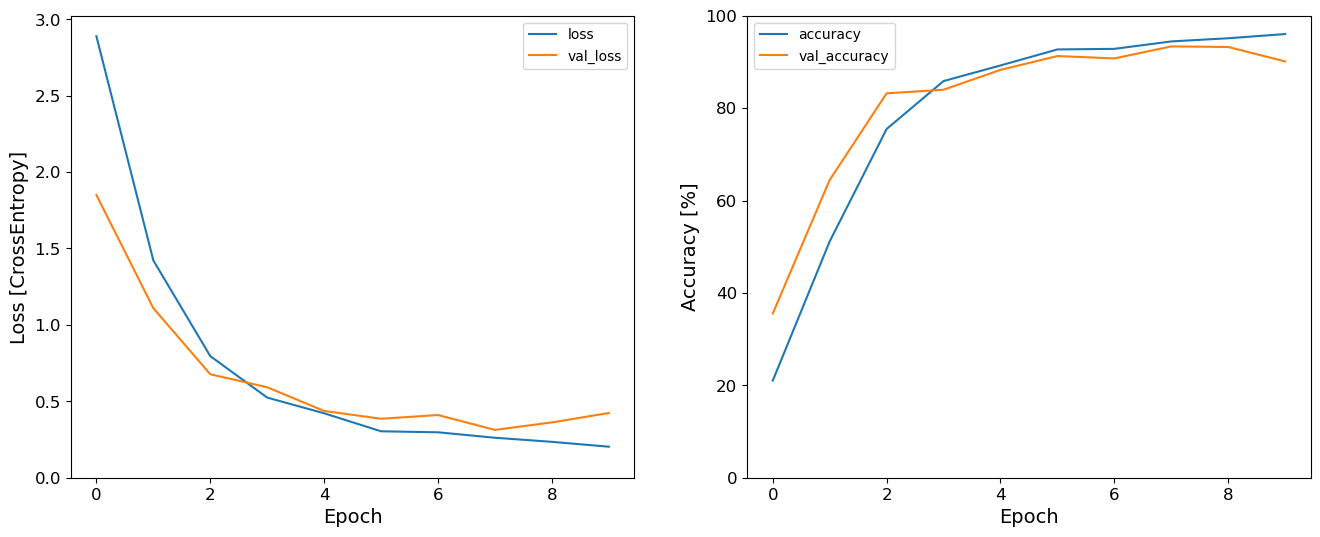

In [58]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### ResNet50 using the top layer as a model output for classification

In [59]:
from crossai_lib.models.nn2d import ResNet50

In [60]:
resnet50 = ResNet50(input_shape=input_shape, num_classes=num_labels)

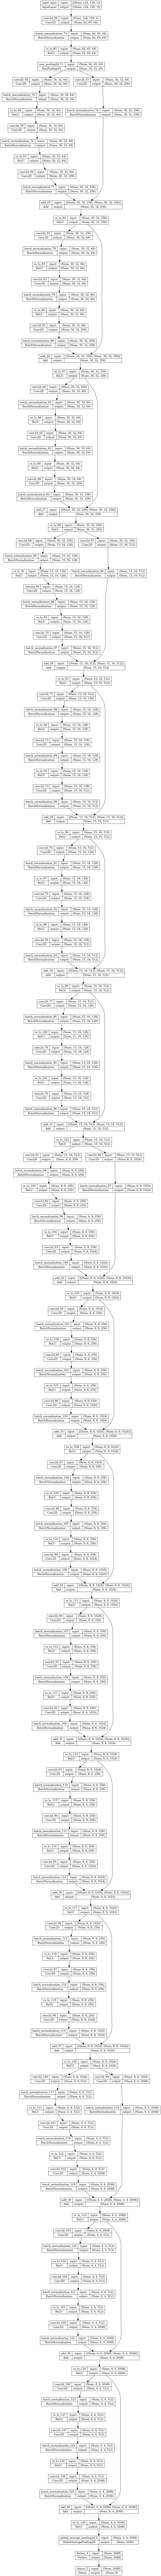

In [61]:
keras.utils.plot_model(resnet50, to_file="ResNet50.png", show_shapes=True)

In [62]:
resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [63]:
history = resnet50.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    verbose=2,
    epochs=10,
)

Epoch 1/10
100/100 - 36s - loss: 43.5822 - accuracy: 0.2261 - val_loss: 30.8749 - val_accuracy: 0.1966 - 36s/epoch - 361ms/step
Epoch 2/10
100/100 - 6s - loss: 21.9373 - accuracy: 0.6764 - val_loss: 16.5688 - val_accuracy: 0.5690 - 6s/epoch - 65ms/step
Epoch 3/10
100/100 - 7s - loss: 12.2018 - accuracy: 0.8398 - val_loss: 10.5137 - val_accuracy: 0.3789 - 7s/epoch - 65ms/step
Epoch 4/10
100/100 - 6s - loss: 7.6709 - accuracy: 0.8708 - val_loss: 8.0076 - val_accuracy: 0.3203 - 6s/epoch - 65ms/step
Epoch 5/10
100/100 - 7s - loss: 5.3344 - accuracy: 0.8928 - val_loss: 5.4305 - val_accuracy: 0.5651 - 7s/epoch - 65ms/step
Epoch 6/10
100/100 - 7s - loss: 3.9381 - accuracy: 0.9094 - val_loss: 4.0774 - val_accuracy: 0.7005 - 7s/epoch - 65ms/step
Epoch 7/10
100/100 - 7s - loss: 3.1363 - accuracy: 0.9142 - val_loss: 4.0318 - val_accuracy: 0.4193 - 7s/epoch - 65ms/step
Epoch 8/10
100/100 - 7s - loss: 2.6258 - accuracy: 0.9158 - val_loss: 2.7492 - val_accuracy: 0.8112 - 7s/epoch - 65ms/step
Epoch 9

In [64]:
resnet50.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 13ms/step - loss: 2.4516 - accuracy: 0.7668


{'loss': 2.4516072273254395, 'accuracy': 0.7668269276618958}

Text(0, 0.5, 'Accuracy [%]')

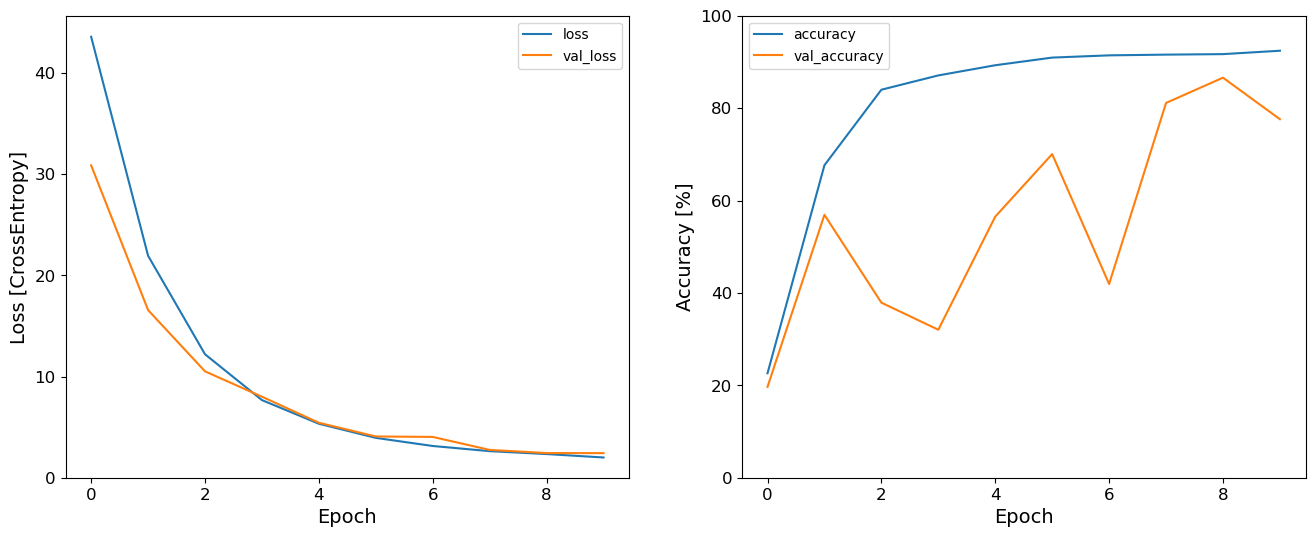

In [65]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [66]:
#### InceptionV1 or GoogLenet

In [67]:
from crossai_lib.models.nn2d import InceptionV1

In [68]:
inceptionv1 = InceptionV1(input_shape=input_shape, num_classes=num_labels)
inceptionv1.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 conv_1_7x7/2 (Conv2D)       (None, 62, 65, 64)           3200      ['input_layer[0][0]']         
                                                                                                  
 max_pool_1_3x3/2 (MaxPooli  (None, 31, 33, 64)           0         ['conv_1_7x7/2[0][0]']        
 ng2D)                                                                                            
                                                                                                  
 conv_2a_3x3/1 (Conv2D)      (None, 31, 33, 64)           4160      ['max_pool_1_3x3/2[

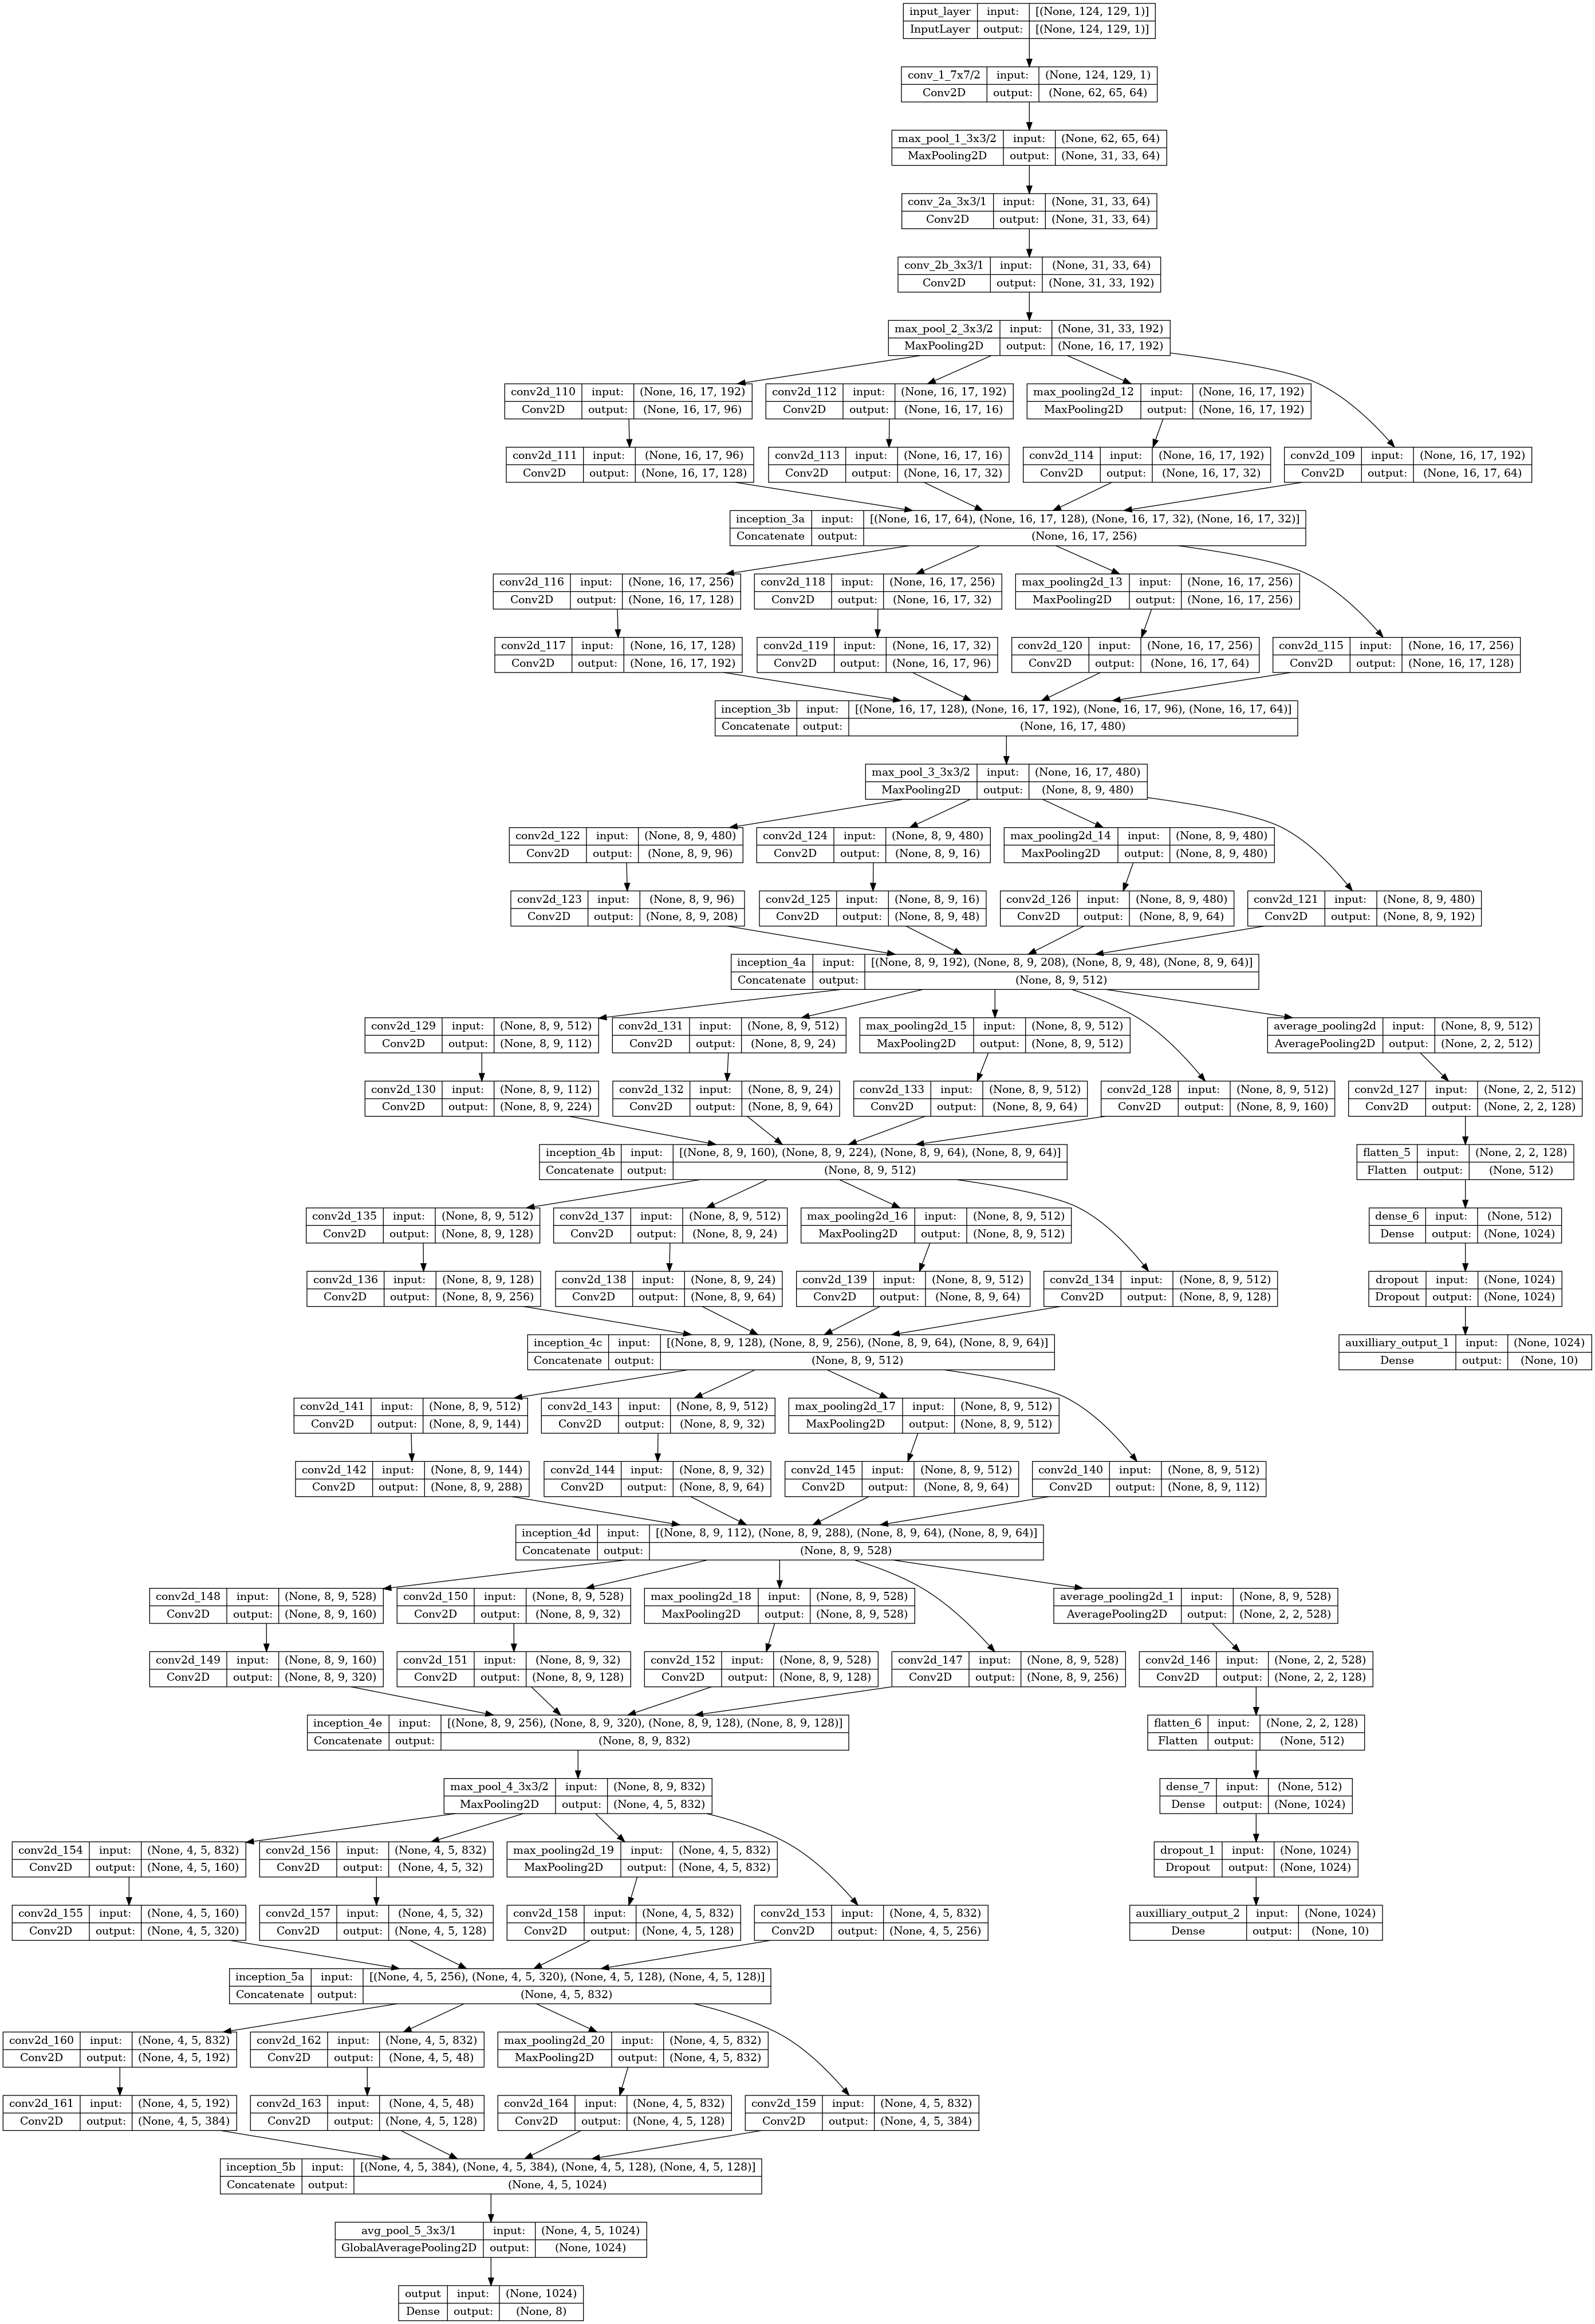

In [69]:
keras.utils.plot_model(inceptionv1, to_file='InceptionV1.png', show_shapes=True)

In [70]:
inceptionv1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [71]:
EPOCHS = 10
history = inceptionv1.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 26s 57ms/step - loss: 6.5547 - output_loss: 2.2026 - auxilliary_output_1_loss: 2.1407 - auxilliary_output_2_loss: 2.1360 - output_accuracy: 0.1281 - auxilliary_output_1_accuracy: 0.1244 - auxilliary_output_2_accuracy: 0.1303 - val_loss: 6.3523 - val_output_loss: 2.0989 - val_auxilliary_output_1_loss: 2.0895 - val_auxilliary_output_2_loss: 2.0923 - val_output_accuracy: 0.1081 - val_auxilliary_output_1_accuracy: 0.1367 - val_auxilliary_output_2_accuracy: 0.1081
Epoch 2/10
100/100 [==============================] - 5s 50ms/step - loss: 6.0827 - output_loss: 2.0209 - auxilliary_output_1_loss: 1.9697 - auxilliary_output_2_loss: 2.0222 - output_accuracy: 0.1667 - auxilliary_output_1_accuracy: 0.2197 - auxilliary_output_2_accuracy: 0.1767 - val_loss: 5.2758 - val_output_loss: 1.8111 - val_auxilliary_output_1_loss: 1.6775 - val_auxilliary_output_2_loss: 1.7182 - val_output_accuracy: 0.2747 - val_auxilliary_output_1_accuracy: 0.3333 - val_au

In [72]:
inceptionv1.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 11ms/step - loss: 0.8351 - output_loss: 0.2687 - auxilliary_output_1_loss: 0.2441 - auxilliary_output_2_loss: 0.2543 - output_accuracy: 0.9171 - auxilliary_output_1_accuracy: 0.9207 - auxilliary_output_2_accuracy: 0.9231


{'loss': 0.8351479768753052,
 'output_loss': 0.2687334716320038,
 'auxilliary_output_1_loss': 0.24406003952026367,
 'auxilliary_output_2_loss': 0.25432318449020386,
 'output_accuracy': 0.917067289352417,
 'auxilliary_output_1_accuracy': 0.9206730723381042,
 'auxilliary_output_2_accuracy': 0.9230769276618958}

In [73]:
metrics = history.history
for key in metrics.keys():
    print(key)

loss
output_loss
auxilliary_output_1_loss
auxilliary_output_2_loss
output_accuracy
auxilliary_output_1_accuracy
auxilliary_output_2_accuracy
val_loss
val_output_loss
val_auxilliary_output_1_loss
val_auxilliary_output_2_loss
val_output_accuracy
val_auxilliary_output_1_accuracy
val_auxilliary_output_2_accuracy


Text(0, 0.5, 'Accuracy [%]')

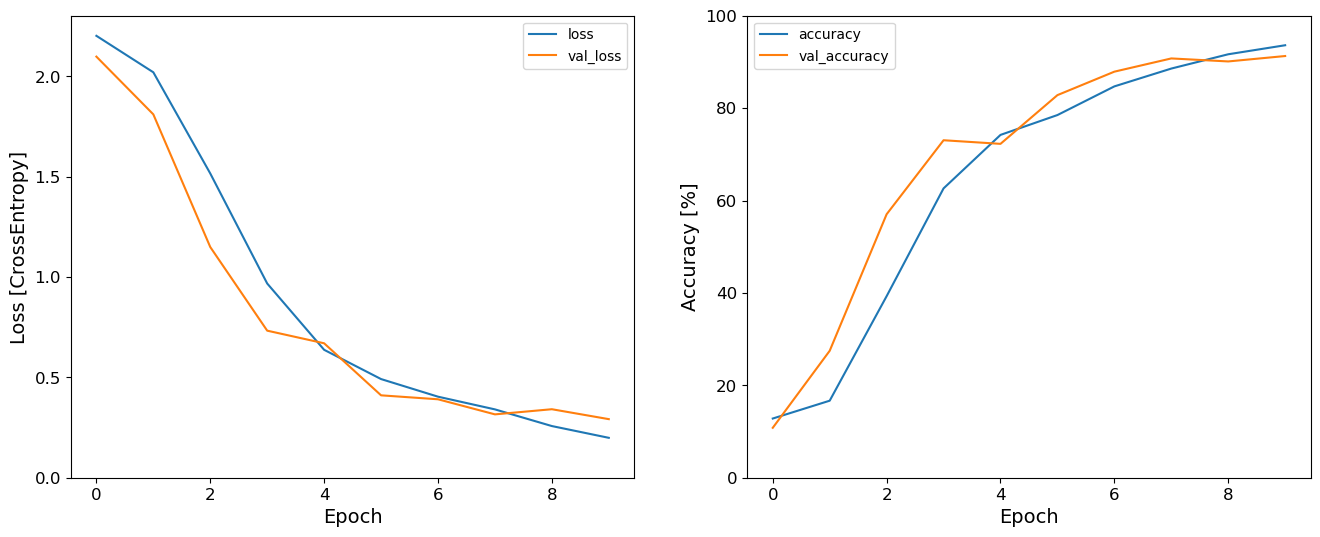

In [74]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['output_loss'], metrics['val_output_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['output_accuracy']), 100*np.array(metrics['val_output_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [75]:
import seaborn as sns

##### Display a confusion matrix
Use a confusion matrix to check how well the model did classifying each of the commands in the test set:

In [76]:
y_pred = resnet50.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 11ms/step


In [77]:
y_pred = tf.argmax(y_pred, axis=1)

In [78]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

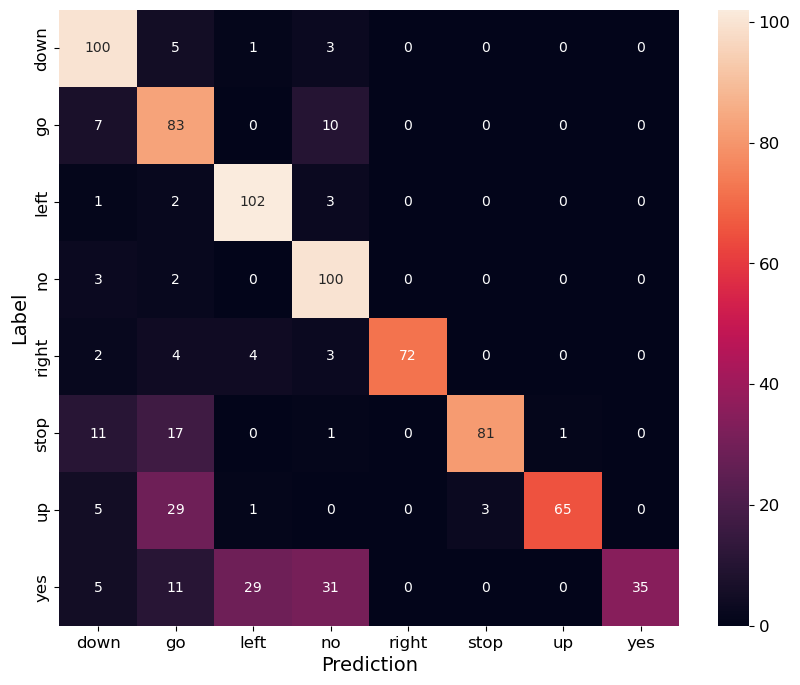

In [79]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))

sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### InceptionV?

In [80]:
# from crossai_lib.models.nn2d._resnet34

## Time of execution of the NB processing

In [81]:
print("Time of execution:", (time.time() - start_time) / 60, "minutes")

Time of execution: 6.910344262917836 minutes
